<a href="https://colab.research.google.com/github/sarychief/cv-tasks/blob/main/kaggle_plates_resnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import zipfile
import numpy as np 
import pandas as pd

with zipfile.ZipFile('/content/drive/MyDrive/plates.zip', 'r') as zip_obj: 
	# раззипуем файл и выложим все в созданную папку
	zip_obj.extractall('/working/')
    
print('After zip extraction:')
print(os.listdir("/working/"))

After zip extraction:
['__MACOSX', 'plates']


In [ ]:
!pip install wandb
!wandb login

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.8 MB 5.2 MB/s 
     |████████████████████████████████| 156 kB 61.2 MB/s 
     |████████████████████████████████| 181 kB 54.5 MB/s 
     |████████████████████████████████| 63 kB 1.9 MB/s 
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8806 sha256=0230ef4efce70ec5dcb750b119725044963742b618ff71d659080170a0332c48
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built pathtools
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
import wandb

wandb.init(project="kaggle_plates")

wandb: Currently logged in as: sarychief. Use `wandb login --relogin` to force relogin


In [ ]:
data_root = '/working/plates'
print(os.listdir(data_root))

['test', 'train', '.DS_Store']


In [ ]:
import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val'

class_names = ['cleaned', 'dirty']

for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        if i % 6 != 0:
            dest_dir = os.path.join(train_dir, class_name) 
        else:
            dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 21/21 [00:00<00:00, 2927.23it/s]


In [ ]:
import torch
import numpy as np
import torchvision
import matplotlib.pyplot as plt
import time
import copy

from torchvision import transforms, models

# Чтобы вместо картинок нам на вход приходили тензоры, делаем 

# необходимые трансформации traindataset
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Вырезает рандомную часть картинки и resize
    transforms.RandomHorizontalFlip(),  # случайным образом отражать изображения
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# необходимые трансформации testdataset
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)), # ужимаем изображения до размера 224 на 224 (в случае ResNet => ImageNet)
    transforms.ToTensor(),         
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Нормируем к изначальному виду
])

# ImageFolder метод позволяет итерироваться по парам: объект - значение (название папки) 
train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)

batch_size = 8

# Создание батчей
train_dataloader = torch.utils.data.DataLoader( 
    train_dataset,          # Полученный датасет
    batch_size=batch_size,  # Размер батча
    shuffle=True,           # Перемешать датасет перед началом эпохи
    num_workers=batch_size 
    )

val_dataloader = torch.utils.data.DataLoader(
    val_dataset, 
    batch_size=batch_size, 
    shuffle=False,          # Не перемешивать датасет перед началом эпохи
    num_workers=batch_size
    )

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
print("Количество бачей:", len(train_dataloader))
print("Количество картинок в:", len(train_dataset))

Количество бачей: 4
Количество картинок в: 32


Количество картинок должно нацело делиться на размер батча, иначе батч будет неполный => неверные статистики

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


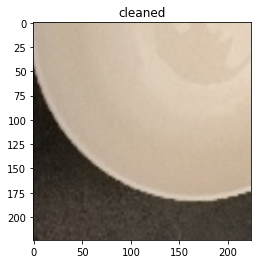

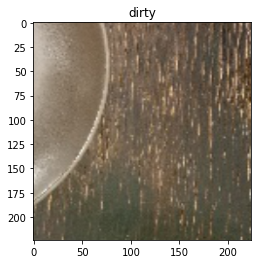

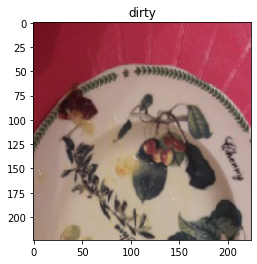

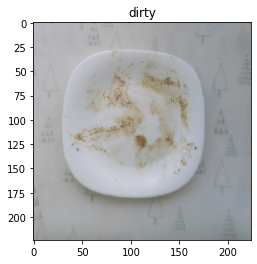

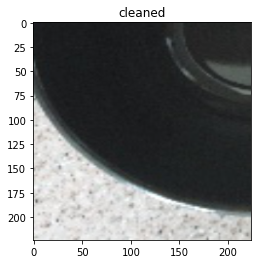

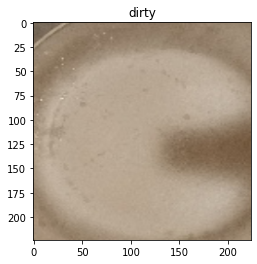

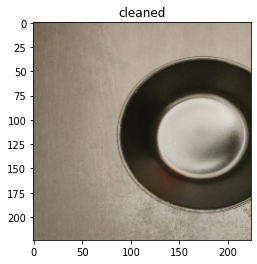

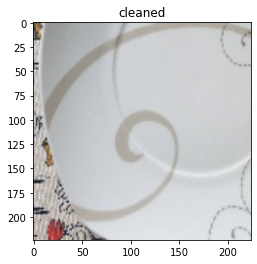

In [ ]:
# Функция возврата изображения к исходному (resize + normal)
def show_input(input_tensor, title=''):
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

# Тренировка 
Для нее мы будем использовать: 
- Модель архитектуры ResNet
- loss
- Grad descent
- Планировщик шага градспуска


In [ ]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
  # Итерируемся по эпохам
  for epoch in range(num_epochs):
    print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)
    
    # сначала обучаем, потом валидируем 
    for phase in ['train', 'val']:

      if phase == 'train':
        dataloader = train_dataloader
        scheduler.step()
        model.train()  
      else:
        dataloader = val_dataloader
        model.eval()   # для того, чтобы не было пересчета градиентов

      running_loss = 0.
      running_acc = 0.

      # Iterate over data.
      for inputs, labels in tqdm(dataloader):
        inputs = inputs.to(device)  # Тензор с изображениями переводим на GPU
        labels = labels.to(device)  # Тензор с лейблами переводим на GPU
        
        optimizer.zero_grad()       # Обнуление градиентов

        # чтобы считались только лоссы, а не вся история их получения
        with torch.set_grad_enabled(phase == 'train'):
          # предикты
          preds = model(inputs)
          # значение потери
          loss_value = loss(preds, labels)
          # предсказанный класс
          preds_class = preds.argmax(dim=1)

          # backward + optimize only if in training phase
          if phase == 'train':
            # считаем градиенты
            loss_value.backward()
            # делаем шаг градспуска
            optimizer.step()

        # описательная статистика модели - накапливаем лосс и метрику
        running_loss += loss_value.item()
        running_acc += (preds_class == labels.data).float().mean()

      epoch_loss = running_loss / len(dataloader)
      epoch_acc = running_acc / len(dataloader)

      print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)

  return model

In [ ]:
# берем модель ResNet18 с предобученными весами (pretrained=True)
model = models.resnet18(pretrained=True)

# Отключаем пересчет градиентов по каждому слою
for param in model.parameters():
    param.requires_grad = False

# Меняем ПОСЛЕДНИЙ полносвязный слой
model.fc = torch.nn.Linear(model.fc.in_features,  # сколько нейронов на вход
                           2                      # Сколько нейронов на выход
                           )

# Переход на GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Определяем потерю - бинарная кросс-энтропия
loss = torch.nn.CrossEntropyLoss()
# Алгоритм-оптимизатор
optimizer = torch.optim.Adam(model.parameters(),  # Параметры модели
                             amsgrad=True,        # какая-то полезная фича
                             lr=1.0e-3            # Learning rate - скорость обучения
                             )

# Планировщик шагов градспуска
scheduler = torch.optim.lr_scheduler.StepLR(optimizer,    # Обернутый оптимизатор
                                            step_size=7,  # Каждые n шагов снижаем скорость
                                            gamma=0.1,    # коэфицент снижения
                                            verbose=True  # Выводим сообщение по каждому обновлению
                                            )

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

Adjusting learning rate of group 0 to 1.0000e-03.


In [ ]:
train_model(model,          # Сама модель
            loss,           # Функция потерь
            optimizer,      # Оптимизатор
            scheduler,      # Шедулер
            num_epochs=50   # Количество эпох
            );

Epoch 0/49:
Adjusting learning rate of group 0 to 1.0000e-05.


  0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 4/4 [00:03<00:00,  1.26it/s]

train Loss: 0.4877 Acc: 0.7500



100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

val Loss: 0.5384 Acc: 0.7500
Epoch 1/49:


Adjusting learning rate of group 0 to 1.0000e-05.


100%|██████████| 4/4 [00:03<00:00,  1.27it/s]

train Loss: 0.4692 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

val Loss: 0.5431 Acc: 0.7500
Epoch 2/49:


Adjusting learning rate of group 0 to 1.0000e-05.


100%|██████████| 4/4 [00:03<00:00,  1.23it/s]

train Loss: 0.4899 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

val Loss: 0.5420 Acc: 0.7500
Epoch 3/49:


Adjusting learning rate of group 0 to 1.0000e-05.


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

train Loss: 0.4305 Acc: 0.9375



100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

val Loss: 0.5369 Acc: 0.7500
Epoch 4/49:


Adjusting learning rate of group 0 to 1.0000e-05.


100%|██████████| 4/4 [00:03<00:00,  1.26it/s]

train Loss: 0.4480 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.05it/s]

val Loss: 0.5396 Acc: 0.6250
Epoch 5/49:


Adjusting learning rate of group 0 to 1.0000e-05.


100%|██████████| 4/4 [00:03<00:00,  1.26it/s]

train Loss: 0.4659 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

val Loss: 0.5441 Acc: 0.6250
Epoch 6/49:


Adjusting learning rate of group 0 to 1.0000e-05.


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

train Loss: 0.4289 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

val Loss: 0.5410 Acc: 0.6250
Epoch 7/49:


Adjusting learning rate of group 0 to 1.0000e-06.


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

train Loss: 0.4903 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

val Loss: 0.5441 Acc: 0.6250
Epoch 8/49:


Adjusting learning rate of group 0 to 1.0000e-06.


100%|██████████| 4/4 [00:03<00:00,  1.26it/s]

train Loss: 0.4592 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

val Loss: 0.5535 Acc: 0.6250
Epoch 9/49:


Adjusting learning rate of group 0 to 1.0000e-06.


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

train Loss: 0.4311 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

val Loss: 0.5616 Acc: 0.6250
Epoch 10/49:


Adjusting learning rate of group 0 to 1.0000e-06.


100%|██████████| 4/4 [00:03<00:00,  1.28it/s]

train Loss: 0.4558 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

val Loss: 0.5606 Acc: 0.6250
Epoch 11/49:


Adjusting learning rate of group 0 to 1.0000e-06.


100%|██████████| 4/4 [00:03<00:00,  1.26it/s]

train Loss: 0.4279 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

val Loss: 0.5542 Acc: 0.6250
Epoch 12/49:


Adjusting learning rate of group 0 to 1.0000e-06.


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

train Loss: 0.5055 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

val Loss: 0.5538 Acc: 0.6250
Epoch 13/49:


Adjusting learning rate of group 0 to 1.0000e-06.


100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

train Loss: 0.4191 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

val Loss: 0.5386 Acc: 0.7500
Epoch 14/49:


Adjusting learning rate of group 0 to 1.0000e-07.


100%|██████████| 4/4 [00:03<00:00,  1.26it/s]

train Loss: 0.4560 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

val Loss: 0.5308 Acc: 0.6250
Epoch 15/49:


Adjusting learning rate of group 0 to 1.0000e-07.


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

train Loss: 0.5265 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

val Loss: 0.5382 Acc: 0.6250
Epoch 16/49:


Adjusting learning rate of group 0 to 1.0000e-07.


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

train Loss: 0.4616 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

val Loss: 0.5477 Acc: 0.6250
Epoch 17/49:


Adjusting learning rate of group 0 to 1.0000e-07.


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

train Loss: 0.4915 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

val Loss: 0.5461 Acc: 0.6250
Epoch 18/49:


Adjusting learning rate of group 0 to 1.0000e-07.


100%|██████████| 4/4 [00:03<00:00,  1.26it/s]

train Loss: 0.5016 Acc: 0.8750



100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

val Loss: 0.5382 Acc: 0.7500
Epoch 19/49:


Adjusting learning rate of group 0 to 1.0000e-07.


100%|██████████| 4/4 [00:03<00:00,  1.26it/s]

train Loss: 0.5723 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

val Loss: 0.5369 Acc: 0.7500
Epoch 20/49:


Adjusting learning rate of group 0 to 1.0000e-07.


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

train Loss: 0.4855 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

val Loss: 0.5446 Acc: 0.7500
Epoch 21/49:


Adjusting learning rate of group 0 to 1.0000e-08.


100%|██████████| 4/4 [00:03<00:00,  1.26it/s]

train Loss: 0.4696 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

val Loss: 0.5513 Acc: 0.6250
Epoch 22/49:


Adjusting learning rate of group 0 to 1.0000e-08.


100%|██████████| 4/4 [00:03<00:00,  1.26it/s]

train Loss: 0.5210 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

val Loss: 0.5520 Acc: 0.6250
Epoch 23/49:


Adjusting learning rate of group 0 to 1.0000e-08.


100%|██████████| 4/4 [00:03<00:00,  1.26it/s]

train Loss: 0.4562 Acc: 0.8438



100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

val Loss: 0.5573 Acc: 0.6250
Epoch 24/49:


Adjusting learning rate of group 0 to 1.0000e-08.


100%|██████████| 4/4 [00:03<00:00,  1.26it/s]

train Loss: 0.4762 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

val Loss: 0.5577 Acc: 0.6250
Epoch 25/49:


Adjusting learning rate of group 0 to 1.0000e-08.


100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

train Loss: 0.4415 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

val Loss: 0.5620 Acc: 0.6250
Epoch 26/49:


Adjusting learning rate of group 0 to 1.0000e-08.


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

train Loss: 0.4296 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

val Loss: 0.5395 Acc: 0.7500
Epoch 27/49:


Adjusting learning rate of group 0 to 1.0000e-08.


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

train Loss: 0.4130 Acc: 0.8750



100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

val Loss: 0.5380 Acc: 0.7500
Epoch 28/49:


Adjusting learning rate of group 0 to 1.0000e-09.


100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

train Loss: 0.4913 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  1.03it/s]

val Loss: 0.5448 Acc: 0.6250
Epoch 29/49:


Adjusting learning rate of group 0 to 1.0000e-09.


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

train Loss: 0.4949 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

val Loss: 0.5377 Acc: 0.6250
Epoch 30/49:


Adjusting learning rate of group 0 to 1.0000e-09.


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

train Loss: 0.4778 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

val Loss: 0.5479 Acc: 0.7500
Epoch 31/49:


Adjusting learning rate of group 0 to 1.0000e-09.


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

train Loss: 0.5125 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.02it/s]

val Loss: 0.5473 Acc: 0.7500
Epoch 32/49:


Adjusting learning rate of group 0 to 1.0000e-09.


100%|██████████| 4/4 [00:03<00:00,  1.26it/s]

train Loss: 0.4726 Acc: 0.8438



100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

val Loss: 0.5467 Acc: 0.6250
Epoch 33/49:


Adjusting learning rate of group 0 to 1.0000e-09.


100%|██████████| 4/4 [00:03<00:00,  1.26it/s]

train Loss: 0.4496 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

val Loss: 0.5481 Acc: 0.6250
Epoch 34/49:


Adjusting learning rate of group 0 to 1.0000e-09.


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

train Loss: 0.4524 Acc: 0.8125



100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

val Loss: 0.5407 Acc: 0.7500
Epoch 35/49:


Adjusting learning rate of group 0 to 1.0000e-10.


100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

train Loss: 0.4671 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

val Loss: 0.5470 Acc: 0.6250
Epoch 36/49:


Adjusting learning rate of group 0 to 1.0000e-10.


100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

train Loss: 0.4411 Acc: 0.9062



100%|██████████| 1/1 [00:00<00:00,  1.04it/s]

val Loss: 0.5478 Acc: 0.6250
Epoch 37/49:


Adjusting learning rate of group 0 to 1.0000e-10.


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

train Loss: 0.5100 Acc: 0.7812



100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

val Loss: 0.5489 Acc: 0.6250
Epoch 38/49:


Adjusting learning rate of group 0 to 1.0000e-10.


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

train Loss: 0.4914 Acc: 0.8125



100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

val Loss: 0.5519 Acc: 0.6250
Epoch 39/49:


Adjusting learning rate of group 0 to 1.0000e-10.


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

train Loss: 0.4890 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

val Loss: 0.5498 Acc: 0.6250
Epoch 40/49:


Adjusting learning rate of group 0 to 1.0000e-10.


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

train Loss: 0.4548 Acc: 0.8125



100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

val Loss: 0.5532 Acc: 0.6250
Epoch 41/49:


Adjusting learning rate of group 0 to 1.0000e-10.


100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

train Loss: 0.5036 Acc: 0.8125



100%|██████████| 1/1 [00:01<00:00,  1.01s/it]

val Loss: 0.5498 Acc: 0.6250
Epoch 42/49:


Adjusting learning rate of group 0 to 1.0000e-11.


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

train Loss: 0.4300 Acc: 0.8750



100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

val Loss: 0.5544 Acc: 0.6250
Epoch 43/49:


Adjusting learning rate of group 0 to 1.0000e-11.


100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

train Loss: 0.5040 Acc: 0.7500



100%|██████████| 1/1 [00:01<00:00,  1.02s/it]

val Loss: 0.5461 Acc: 0.7500
Epoch 44/49:


Adjusting learning rate of group 0 to 1.0000e-11.


100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

train Loss: 0.4983 Acc: 0.7812



100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

val Loss: 0.5409 Acc: 0.7500
Epoch 45/49:


Adjusting learning rate of group 0 to 1.0000e-11.


100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

train Loss: 0.5261 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

val Loss: 0.5331 Acc: 0.7500
Epoch 46/49:


Adjusting learning rate of group 0 to 1.0000e-11.


100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

train Loss: 0.5729 Acc: 0.7188



100%|██████████| 1/1 [00:00<00:00,  1.01it/s]

val Loss: 0.5256 Acc: 0.7500
Epoch 47/49:


Adjusting learning rate of group 0 to 1.0000e-11.


100%|██████████| 4/4 [00:03<00:00,  1.25it/s]

train Loss: 0.4617 Acc: 0.8125



100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

val Loss: 0.5478 Acc: 0.6250
Epoch 48/49:


Adjusting learning rate of group 0 to 1.0000e-11.


100%|██████████| 4/4 [00:03<00:00,  1.26it/s]

train Loss: 0.5177 Acc: 0.8125



100%|██████████| 1/1 [00:01<00:00,  1.00s/it]

val Loss: 0.5405 Acc: 0.6250
Epoch 49/49:


Adjusting learning rate of group 0 to 1.0000e-12.


100%|██████████| 4/4 [00:03<00:00,  1.24it/s]

train Loss: 0.4655 Acc: 0.8125



100%|██████████| 1/1 [00:00<00:00,  1.00it/s]

val Loss: 0.5346 Acc: 0.6250


## Предсказание 

In [ ]:
test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'),        # Папка с предсказаниями
                os.path.join(test_dir, 'future_Class')) # создаем папку для будущих предсказанных классов

'test/future_Class'

In [ ]:
# перегружаем класс ImageFolder, который будет отдавать еще и путь к изображению
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths('/content/test', val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [ ]:
# переходим в режим теста
model.eval()

# само предсказание
test_predictions = []
# путь к предсказанной картинке
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader): # лейбы пустые
    inputs = inputs.to(device)                      # переводим на гпу
    with torch.set_grad_enabled(False):             # выключаем градиенты
        preds = model(inputs)                       # считаем предикты
    test_predictions.append(          
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

100%|██████████| 93/93 [01:05<00:00,  1.42it/s]


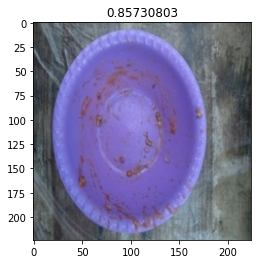

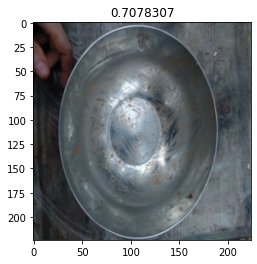

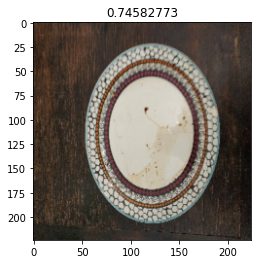

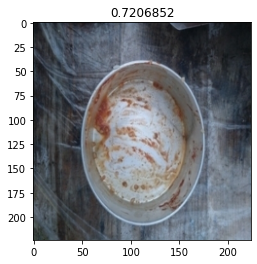

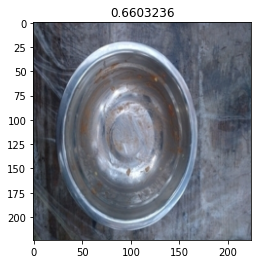

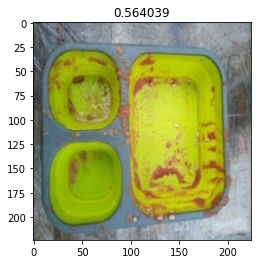

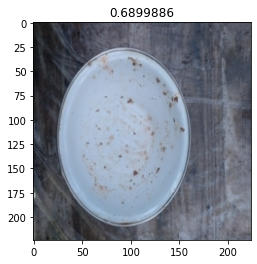

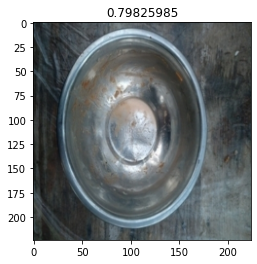

In [ ]:
inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

In [ ]:
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})

In [ ]:
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('/kaggle/working/test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


,label
id,
/content/test/future_Class/0000,dirty
/content/test/future_Class/0001,dirty
/content/test/future_Class/0002,dirty
/content/test/future_Class/0003,dirty
/content/test/future_Class/0004,dirty
/content/test/future_Class/0005,dirty


In [ ]:
# submission_df.to_csv('submission.csv')
# !rm -rf train val test # в случае kaggle лучше все удалять